# [Grounding with Bing Search](https://learn.microsoft.com/en-us/azure/ai-services/agents/how-to/tools/bing-grounding?tabs=python&pivots=overview)
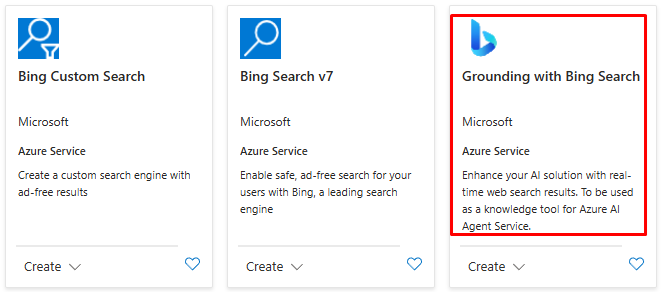<br/><br/>
**Grounding with Bing Search** allows our Azure AI Agents to incorporate real-time public web data when generating responses.<br/>
We need to create a Grounding with Bing Search resource, and then connect this resource to your Azure AI Agents.
<br/>When a user sends a query, Azure AI Agents decide if Grounding with Bing Search should be leveraged or not. If so, it will leverage Bing to search over public web data and return relevant chunks. Lastly, Azure AI Agents will use returned chunks to generate a response.<br/><br/>
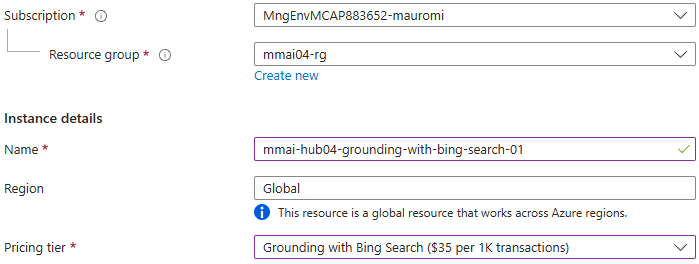
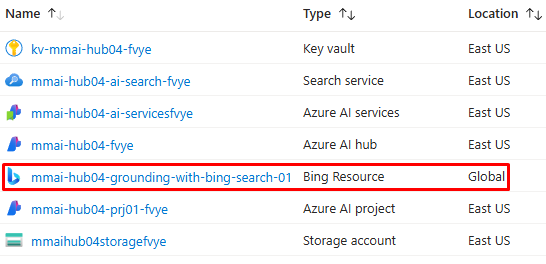
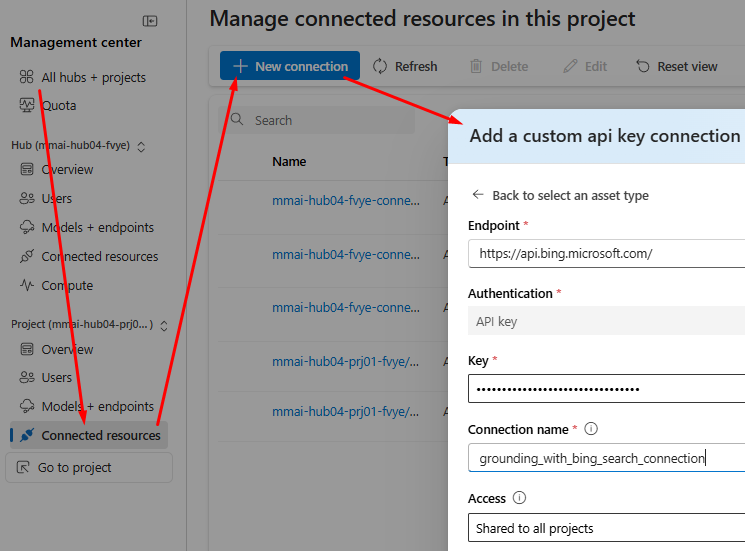
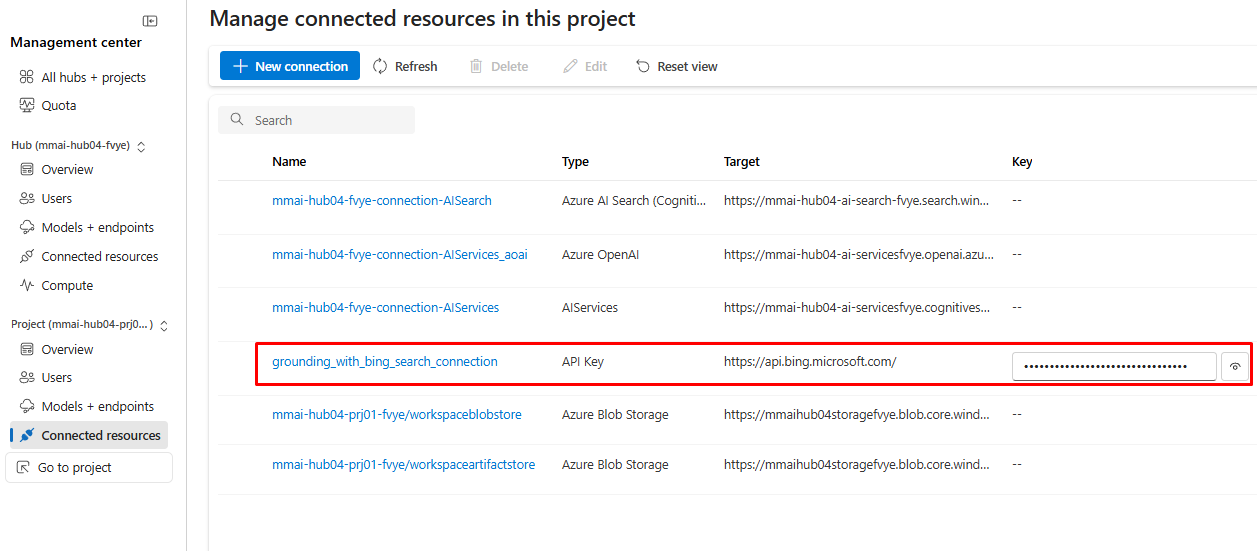

# Constants

## Only if needed
```
import os

# Login with tenant ID
os.system("az login --tenant 3ad0b905-34ab-4116-93d9-c1dcc2d35af6 --output none")

# Set the subscription programmatically
os.system("az account set --subscription eca2eddb-0f0c-4351-a634-52751499eeea")
```

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions_NEW import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")


project_endpoint = os.environ["AIF_STD_PROJECT_ENDPOINT"]
deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Endpoint: <{project_endpoint}>')
print(f"azure-ai-projects library installed version: {importlib.metadata.version("azure-ai-projects")}")
print(f"azure-ai-agents library installed version: {importlib.metadata.version("azure-ai-agents")}")

Environment variables have been loaded ;-)
Project Endpoint: <https://aif2stdsvhdu2.services.ai.azure.com/api/projects/aif2stdwusprj01hdu2>
azure-ai-projects library installed version: 1.0.0
azure-ai-agents library installed version: 1.1.0


# [Create AI Foundry Agent Client](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-agents-readme?view=azure-python-preview)
**Note**: I could create the `project` client rather than the `agent` client, however this is easier to read.<br/>
Please consider that `project_client.agens == agents_client`

In [2]:
from azure.ai.agents import AgentsClient
from azure.identity import DefaultAzureCredential

agents_client = AgentsClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

agents_client

# Create AI Foundry Project Client

In [3]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

project_client

# Create the BingGroundingTool in 2 steps

## First, retrieve the BING Connection already associated to the AI Foundry project...

In [4]:
i = 0
for c in project_client.connections.list():
    i += 1
    print (f"{i}) -  {c.id}\n")

1) -  /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/mmaisearch01

2) -  /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/hdu2cosmosdb

3) -  /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/hdu2storage

4) -  /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch

5) -  /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/aif1bassv

In [5]:
bing_connection = project_client.connections.get(name=os.environ["BING_GROUNDING_CONNECTION_NAME"])

print(bing_connection)

{'name': 'groundingwithbingsearch', 'id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch', 'type': 'ApiKey', 'target': 'https://api.bing.microsoft.com/', 'isDefault': True, 'credentials': {'type': 'ApiKey'}, 'metadata': {'type': 'bing_grounding', 'ApiType': 'Azure', 'ResourceId': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/mmcognitivegrp/providers/Microsoft.Bing/accounts/groundingwithbingsearch'}}


## ...then, initialize [`BingGroundingTool`](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-agents-readme?view=azure-python-preview#create-agent-with-bing-grounding) and add the connection id to it

In [6]:
from azure.ai.agents.models import BingGroundingTool
bing = BingGroundingTool(connection_id=bing_connection.id)
print(f"bing.definitions: {bing.definitions}")
print(f"bing.resources: {bing.resources}")

bing.definitions: [{'type': 'bing_grounding', 'bing_grounding': {'search_configurations': [{'connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch', 'market': '', 'set_lang': '', 'count': 5, 'freshness': ''}]}}]
bing.resources: {}


# ***Load*** or ***Create*** an AI Foundry Agent

In [7]:
agents = list(project_client.agents.list_agents())
agents

[]

In [8]:
%%time

# Agent creation
# Notices that FileSearchTool as tool and tool_resources must be added or the assistant unable to search the file

assistant_id = "" # ex: asst_j1qWBdGsjbK4hHcO0M0n3M5p

if assistant_id != "":
    agent = project_client.agents.get_agent(assistant_id=assistant_id)
else:
    agent = project_client.agents.create_agent(
        model=deployment_name,
        name="aiagent-PYTHON-bing",
        instructions="You are helpful assistant",
        tools=bing.definitions, # leave this line commented to create a naked agent ;-)
        headers={"x-ms-enable-preview": "true"}
    )

print(f"Agent: {agent}")

Agent: {'id': 'asst_DKQhKtvznK5Tp6gWzsNKZsUW', 'object': 'assistant', 'created_at': 1758662811, 'name': 'aiagent-PYTHON-bing', 'description': None, 'model': 'gpt-4o', 'instructions': 'You are helpful assistant', 'tools': [{'type': 'bing_grounding', 'bing_grounding': {'search_configurations': [{'connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch', 'count': 5}]}}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {}, 'metadata': {}, 'response_format': 'auto'}
CPU times: user 5.65 ms, sys: 68 μs, total: 5.72 ms
Wall time: 1.1 s


# Create the thread and attach a new message to it

In [9]:
%%time

# Create a thread
thread = project_client.agents.threads.create()
print(f"Created thread: {thread}\n")

Created thread: {'id': 'thread_arIBDablyAaboDReEW3YM731', 'object': 'thread', 'created_at': 1758662812, 'metadata': {}, 'tool_resources': {}}

CPU times: user 4.16 ms, sys: 119 μs, total: 4.28 ms
Wall time: 545 ms


In [10]:
%%time
# Add a user message to the thread
from azure.ai.agents.models import MessageRole

message = project_client.agents.messages.create(
    thread_id=thread.id, 
    role=MessageRole.USER, 
    content= "What's happened yesterday in the world?", #  "Quali sono i programmi TV stasera?" "Quali sono i programmi TV stasera?"
)
print(f"Created message: {message}")

Created message: {'id': 'msg_YqnbBxzA2JI3ax3GbsNXygF1', 'object': 'thread.message', 'created_at': 1758662813, 'assistant_id': None, 'thread_id': 'thread_arIBDablyAaboDReEW3YM731', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': "What's happened yesterday in the world?", 'annotations': []}}], 'attachments': [], 'metadata': {}}
CPU times: user 3.68 ms, sys: 1.07 ms, total: 4.75 ms
Wall time: 572 ms


In [11]:
# let's see the messages associated with the thread

list(project_client.agents.messages.list(thread_id=thread.id))

[{'id': 'msg_YqnbBxzA2JI3ax3GbsNXygF1', 'object': 'thread.message', 'created_at': 1758662813, 'assistant_id': None, 'thread_id': 'thread_arIBDablyAaboDReEW3YM731', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': "What's happened yesterday in the world?", 'annotations': []}}], 'attachments': [], 'metadata': {}}]

# Run the agent syncrhonously

In [12]:
%%time

# Run the agent
run = project_client.agents.runs.create_and_process\
    (thread_id=thread.id, agent_id=agent.id)

print(f"The first time, run finished with status: {run.status}.\n\nRun: {run}")

if run.status == "incomplete":
    print("since the run status is <incomplete>, create a new run")
    run = project_client.agents.runs.create_and_process\
        (thread_id=thread.id, agent_id=agent.id)
    print(f"\n\nThe second time, run finished with status: {run.status}.\n\nRun: {run}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

The first time, run finished with status: incomplete.

Run: {'id': 'run_4EcTYPlzvbVLhdD9Tp7PmEQK', 'object': 'thread.run', 'created_at': 1758662815, 'assistant_id': 'asst_DKQhKtvznK5Tp6gWzsNKZsUW', 'thread_id': 'thread_arIBDablyAaboDReEW3YM731', 'status': 'incomplete', 'started_at': 1758662815, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 1758662817, 'required_action': None, 'last_error': None, 'model': 'gpt-4o', 'instructions': 'You are helpful assistant', 'tools': [{'type': 'bing_grounding', 'bing_grounding': {'search_configurations': [{'connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch', 'count': 5}]}}], 'tool_resources': {}, 'metadata': {}, 'temperature': 1.0, 'top_p': 1.0, 'max_completion_tokens': None, 'max_prompt_tokens': None, 'truncation_strategy': {'type': 'auto', 'last_message

# Check the agent status
Do **NOT** proceed until `<RunStatus.COMPLETED == 'completed'>`

In [13]:
updated_run_status = project_client.agents.runs.get(run_id=run.id, thread_id=thread.id)#.status
updated_run_status

{'id': 'run_Ahk7nn0PxacdqX3hahT9clTA', 'object': 'thread.run', 'created_at': 1758662819, 'assistant_id': 'asst_DKQhKtvznK5Tp6gWzsNKZsUW', 'thread_id': 'thread_arIBDablyAaboDReEW3YM731', 'status': 'completed', 'started_at': 1758662819, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 1758662823, 'required_action': None, 'last_error': None, 'model': 'gpt-4o', 'instructions': 'You are helpful assistant', 'tools': [{'type': 'bing_grounding', 'bing_grounding': {'search_configurations': [{'connection_id': '/subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/aif2stdrg/providers/Microsoft.CognitiveServices/accounts/aif2stdsvhdu2/projects/aif2stdwusprj01hdu2/connections/groundingwithbingsearch', 'count': 5}]}}], 'tool_resources': {}, 'metadata': {}, 'temperature': 1.0, 'top_p': 1.0, 'max_completion_tokens': None, 'max_prompt_tokens': None, 'truncation_strategy': {'type': 'auto', 'last_messages': None}, 'incomplete_details': None, 'usage': {'prompt_toke

# Fetch messages from the thread after the agent run execution

In [14]:
from azure.ai.agents.models import MessageTextContent, MessageImageFileContent, MessageTextFileCitationAnnotation, MessageTextFilePathAnnotation

image_files = []
annotations = []
citations = []

if run.status == 'completed':
    messages = project_client.agents.messages.list(thread_id=thread.id)
    messages_list = list(project_client.agents.messages.list(thread_id=thread.id))  # Convert iterator to a list
    messages_nr = len(messages_list)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages_list), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageTextContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    if type(a) is MessageTextFileCitationAnnotation:
                        print(f">>> Citation in MessageTextContent {j} of message {i}: {a}\n")
                        citations.append(a)
                    elif type(a) is MessageTextFilePathAnnotation:
                        print(f">>> Annotation in MessageTextContent {j} of message {i}: {a}\n")
                        annotations.append(a)
            elif (type(c) is MessageImageFileContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
                image_files.append(c.image_file.file_id)

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 3 messages:


===== MESSAGE 1 =====

Message 1 / CONTENT 1 (MessageTextContent) --> Text: What's happened yesterday in the world?

===== MESSAGE 2 =====

Message 2 / CONTENT 1 (MessageTextContent) --> Text: I'm sorry, but I cannot assist with that request.

===== MESSAGE 3 =====

Message 3 / CONTENT 1 (MessageTextContent) --> Text: Here are some notable events from September 22, 2025:

1. **Climate Action Summit 2025**: Global leaders gathered in New York for the Climate Action Summit, where discussions focused on accelerating efforts to tackle climate change and meet the goals of the Paris Agreement .

2. **Earthquake in Japan**: A powerful earthquake struck off the coast of Honshu, Japan, causing structural damage but fortunately no casualties were reported. Authorities are continuing to assess the situation and conduct rescue and relief operations .

3. **Technology Sector News**: In the tech world, a major announcement was made by a leading tech company about advanceme

# Print annotations from the messages

In [15]:
print (f"Nr. of file path annotations: {len(annotations)}\n")

i=0
for a in annotations:
    i += 1
    print(f"{i} - File annotation paths: {a.text}")
    file_name = a.text.split('/')[-1]
    file_id = a.file_path.file_id

    #agents_client.files.save(file_id=file_id, file_name=file_name)
    project_client.agents.files.save(file_id=file_id, file_name=file_name)
    print(f"\n>>> file <{file_id}> saved as <{file_name}>")
    
    # project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=file_name)
    print(f"File annotation {i} saved as file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

Nr. of file path annotations: 0



# Fetch citations from the messages

In [16]:
print (f"Nr. of file path citations: {len(citations)}\n")

i=0
for a in citations:
    i += 1
    print(f"{i} - citation: {a}")

Nr. of file path citations: 0



# Retrieve and download eventual images

In [17]:
print (f"Nr. of image contents: {len(image_files)}\n")

i=0
# Generate an image file for the bar chart
for image_file in image_files:
    i += 1
    print(f"{i} - Image file id: {image_file}")
    file_name = f"{image_file}.png"
    project_client.agents.files.save(file_id=image_file, file_name=file_name)
    print(f"Image content {i} file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

Nr. of image contents: 0



# Collect all resources for this project

In [18]:
all_agents = list_all_agents(client=project_client)
print(all_agents["summary"])

all_threads = list_all_threads(client=project_client)
print(all_threads["summary"])

all_files = list_all_files(client=project_client)
print(all_files["summary"])

all_runs = list_all_runs(client=project_client)
print(all_runs["summary"])

# all_runsteps=list_all_runsteps(project_client)
# print(all_runsteps["summary"])

# all_messages = list_all_messages(project_client)
# print(all_messages["summary"])

all_vectorstores = list_all_vectorstores(client=project_client)
print(all_vectorstores["summary"])

1 agents
1 threads
0 files
2 runs in 1 threads
0 vector stores


# Teardown for all resources

In [19]:
# delete all vector stores

i=0
for vector_store in all_vectorstores["content"]:
    i += 1
    project_client.agents.vector_stores.delete(vector_store_id=vector_store.id)
    print(f"{i} - Vector store <{vector_store.id}> has been deleted")

all_vectorstores = list_all_vectorstores(client=project_client)

print(f"Vector stores deleted: {i}\n")

Vector stores deleted: 0



In [20]:
# delete all files

i=0
for file in all_files['content']:
    i += 1
    project_client.agents.files.delete(file_id=file.id)
    print(f"{i} - File <{file.filename}> ({file.id}) has been deleted")

all_files = list_all_files(project_client)

print(f"Files deleted: {i}\n")

Files deleted: 0



In [21]:
# delete all threads

i=0
for thread in all_threads["content"]:
    i += 1
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"{i} - Thread <{thread.id}> has been deleted")

all_threads = list_all_threads(project_client)

print(f"Threads deleted: {i}\n")

1 - Thread <thread_arIBDablyAaboDReEW3YM731> has been deleted
Threads deleted: 1



In [22]:
# delete all agents

i=0
for agent in all_agents["content"]:
    i += 1
    project_client.agents.delete_agent(agent_id=agent.id)
    print(f"{i} - Agent <{agent.id}> has been deleted")

all_agents = list_all_agents(client=project_client)

print(f"Agents deleted: {i}\n")

1 - Agent <asst_DKQhKtvznK5Tp6gWzsNKZsUW> has been deleted
Agents deleted: 1



# HIC SUNT LEONES